In [40]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
ratings_data = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None,
                          engine='python', on_bad_lines='skip')
movies_data = pd.read_csv('ml-1m/movies.dat', sep='::', header=None,
                         engine='python', on_bad_lines='skip', encoding='ISO-8859-1')

In [42]:
ratings_data.columns = ['UserID', 'MovieID', 'Ratings', 'Timestamp']
movies_data.columns = ['MovieID', 'Title', 'Genres']

In [43]:
ratings_data.head()

,UserID,MovieID,Ratings,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [44]:
movies_data.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [45]:
movies_data['Index'] = movies_data.index

In [46]:
merged_data = movies_data.merge(ratings_data, on='MovieID')
merged_data.head()

,MovieID,Title,Genres,Index,UserID,Ratings,Timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,0,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,0,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,0,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,0,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,0,10,5,978226474


In [47]:
merged_data.drop(['Title', 'Genres', 'Timestamp'], axis=1, inplace=True)

In [48]:
merged_data.head()

,MovieID,Index,UserID,Ratings
0,1,0,1,5
1,1,0,6,4
2,1,0,8,4
3,1,0,9,5
4,1,0,10,5


In [49]:
userGroup = merged_data.groupby('UserID')

In [50]:
train_users = 1000
train_X = list()

for userID, curUser in userGroup:
    temp = [0]*len(movies_data)
    for num, movie in curUser.iterrows():
        temp[movie['Index']] = movie['Ratings']/5
    train_X.append(temp)
    
    if train_users == 0:
        break
    train_users -= 1

In [51]:
pd.DataFrame(train_X)

,0,1,2,3,4,5,6,7,8,9,...,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.8,0.8,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
visibleUnits = len(movies_data)
hiddenUnits = 50

vb = tf.Variable(tf.zeros([visibleUnits]), dtype=tf.float32, name='vb')
hb = tf.Variable(tf.zeros([hiddenUnits]), dtype=tf.float32, name='hb')
W = tf.Variable(tf.random.normal([visibleUnits, hiddenUnits], stddev=1), dtype=tf.float32, name='W')

In [53]:
@tf.function
def rbm_step(v0):
    _h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
    h0 = tf.nn.relu(tf.sign(_h0 - tf.random.uniform(tf.shape(_h0))))
    
    _v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb)
    v1 = tf.nn.relu(tf.sign(_v1 - tf.random.uniform(tf.shape(_v1))))
    h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)
    
    return h0, v1, h1

In [55]:
epochs = 500
batch_size=100
alpha = 1
errors = []
train_X = np.array(train_X, dtype=np.float32)
for epoch in range(epochs):
    for start in range(0, len(train_X), batch_size):
        end = min(start+batch_size, len(train_X))
        batch = train_X[start:end]
        
        with tf.GradientTape() as tape:
            h0, v1, h1 = rbm_step(batch)
            
            w_pos_grad = tf.matmul(tf.transpose(batch), h0)
            w_neg_grad = tf.matmul(tf.transpose(v1), h1)
            CD = (w_pos_grad - w_neg_grad) / tf.cast(tf.shape(batch)[0], tf.float32)
            
            err = batch-v1
            err_sum = tf.reduce_sum(err*err)
            
        gradients = tape.gradient(err_sum, [W, vb, hb])
        W.assign_add(alpha*CD)
        vb.assign_add(alpha*tf.reduce_mean(batch - v1, axis=0))
        hb.assign_sub(alpha*tf.reduce_mean(h0-h1, axis=0))
    _, v1, _ = rbm_step(train_X)
    err = train_X - v1
    err_sum = tf.reduce_mean(err*err)
    errors.append(err_sum.numpy())
    print('Epoch: {}, Error: {}'.format(epoch, errors[-1]))

Epoch: 0, Error: 0.1261453926563263
Epoch: 1, Error: 0.08628285676240921
Epoch: 2, Error: 0.07329554110765457
Epoch: 3, Error: 0.0665755495429039
Epoch: 4, Error: 0.0632447600364685
Epoch: 5, Error: 0.060237206518650055
Epoch: 6, Error: 0.058423612266778946
Epoch: 7, Error: 0.05731799453496933
Epoch: 8, Error: 0.05678122118115425
Epoch: 9, Error: 0.055667776614427567
Epoch: 10, Error: 0.0552661269903183
Epoch: 11, Error: 0.054862458258867264
Epoch: 12, Error: 0.054170746356248856
Epoch: 13, Error: 0.05437389016151428
Epoch: 14, Error: 0.05399575084447861
Epoch: 15, Error: 0.05333429574966431
Epoch: 16, Error: 0.053328122943639755
Epoch: 17, Error: 0.053282737731933594
Epoch: 18, Error: 0.05296006053686142
Epoch: 19, Error: 0.05263177677989006
Epoch: 20, Error: 0.05253386124968529
Epoch: 21, Error: 0.052732884883880615
Epoch: 22, Error: 0.053013935685157776
Epoch: 23, Error: 0.0526144877076149
Epoch: 24, Error: 0.052539002150297165
Epoch: 25, Error: 0.052405938506126404
Epoch: 26, Error

Epoch: 212, Error: 0.04929007962346077
Epoch: 213, Error: 0.049308087676763535
Epoch: 214, Error: 0.04897342249751091
Epoch: 215, Error: 0.04883531481027603
Epoch: 216, Error: 0.0490119606256485
Epoch: 217, Error: 0.049003008753061295
Epoch: 218, Error: 0.04912634938955307
Epoch: 219, Error: 0.049281276762485504
Epoch: 220, Error: 0.04929187521338463
Epoch: 221, Error: 0.04928220808506012
Epoch: 222, Error: 0.049211710691452026
Epoch: 223, Error: 0.049170952290296555
Epoch: 224, Error: 0.04917234554886818
Epoch: 225, Error: 0.04920167475938797
Epoch: 226, Error: 0.04903429374098778
Epoch: 227, Error: 0.0489904023706913
Epoch: 228, Error: 0.04888249561190605
Epoch: 229, Error: 0.04896894469857216
Epoch: 230, Error: 0.04915742948651314
Epoch: 231, Error: 0.04896343871951103
Epoch: 232, Error: 0.049220971763134
Epoch: 233, Error: 0.04906892031431198
Epoch: 234, Error: 0.04923687130212784
Epoch: 235, Error: 0.04888578876852989
Epoch: 236, Error: 0.04876343160867691
Epoch: 237, Error: 0.049

Epoch: 422, Error: 0.048461802303791046
Epoch: 423, Error: 0.04868435114622116
Epoch: 424, Error: 0.0483141764998436
Epoch: 425, Error: 0.04848135635256767
Epoch: 426, Error: 0.04850337654352188
Epoch: 427, Error: 0.048716552555561066
Epoch: 428, Error: 0.04876719042658806
Epoch: 429, Error: 0.04863778129220009
Epoch: 430, Error: 0.04859362915158272
Epoch: 431, Error: 0.04841507971286774
Epoch: 432, Error: 0.04879565164446831
Epoch: 433, Error: 0.04864344000816345
Epoch: 434, Error: 0.049048133194446564
Epoch: 435, Error: 0.04908904433250427
Epoch: 436, Error: 0.04869077354669571
Epoch: 437, Error: 0.04879821836948395
Epoch: 438, Error: 0.04864488169550896
Epoch: 439, Error: 0.04873446375131607
Epoch: 440, Error: 0.04868686571717262
Epoch: 441, Error: 0.049084048718214035
Epoch: 442, Error: 0.04900738596916199
Epoch: 443, Error: 0.04875113442540169
Epoch: 444, Error: 0.04853847250342369
Epoch: 445, Error: 0.04872504621744156
Epoch: 446, Error: 0.048805784434080124
Epoch: 447, Error: 0.

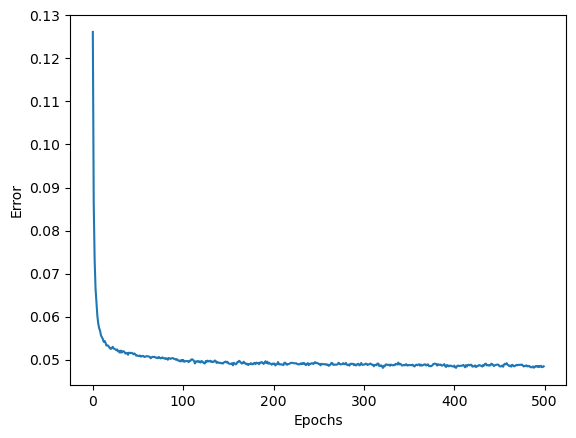

In [60]:
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel("Epochs");

### Recommendations

In [62]:
input_User = np.array([train_X[75]], dtype=np.float32)
def recommend_movies(input_User):
    hh0 = tf.nn.sigmoid(tf.matmul(input_User, W) + hb)
    vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
    return vv1
reconstructed = recommend_movies(input_User)

In [65]:
scored_movies_df_75 = movies_data.copy()
scored_movies_df_75['Recommendation Score'] = reconstructed[0]

In [74]:
user_ID = merged_data.iloc[75]['UserID']
movies_watched = merged_data[merged_data['UserID'] == user_ID]['MovieID'].to_list()

In [79]:
recommended_movies = scored_movies_df_75[~scored_movies_df_75.MovieID.isin(movies_watched)].sort_values(
                                                                                by=['Recommendation Score'],
                                                                                ascending=False)

In [83]:
top_20_recommendations = recommended_movies.head(20)
print(top_20_recommendations[['Title', 'Recommendation Score']])

                                            Title  Recommendation Score
2789                       American Beauty (1999)              0.755840
2327                   Shakespeare in Love (1998)              0.659263
1959                   Saving Private Ryan (1998)              0.641068
523                       Schindler's List (1993)              0.641068
2502                           Matrix, The (1999)              0.636455
2928                  Being John Malkovich (1999)              0.622463
1180               Raiders of the Lost Ark (1981)              0.622462
2693                      Sixth Sense, The (1999)              0.593875
1245                         Groundhog Day (1993)              0.586620
604                                  Fargo (1996)              0.584195
1539                          Men in Black (1997)              0.574446
1656                     Good Will Hunting (1997)              0.562177
3045                           Toy Story 2 (1999)              0

## Deep Belief Networks

In [100]:
class DBN:
    def __init__(self, VisibleUnits, HiddenUnits, k=1, learning_rate=0.01):
        self.VisibleUnits = VisibleUnits
        self.HiddenUnits = HiddenUnits
        self.k = k
        self.lr = learning_rate
        
        self.weights = list()
        self.hidden_biases = list()
        self.visible_biases = list()
        input_size = self.VisibleUnits
        for h_unit in self.HiddenUnits:
            weight = tf.Variable(tf.random.normal([input_size, h_unit], mean=0, stddev=1, dtype=tf.float32), 
                                        name='weight_{}'.format(h_unit))
            hidden_bias = tf.Variable(tf.zeros([h_unit], dtype=tf.float32), 
                                        name='hidden_bias_{}'.format(h_unit))
            visible_bias = tf.Variable(tf.zeros([input_size], dtype=tf.float32),
                                        name='visible_bias_{}'.format(h_unit))
            
            self.weights.append(weight)
            self.hidden_biases.append(hidden_bias)
            self.visible_biases.append(visible_bias)
            
            input_size = h_unit
            
    def sample_h_given_v(self, v0_sample, layer_idx):
        v0_sample = tf.cast(v0_sample, dtype=tf.float32)
        h1_mean = tf.nn.sigmoid(tf.matmul(v0_sample, self.weights[layer_idx])+self.hidden_biases[layer_idx])
        h1_sample = tf.nn.relu(tf.sign(h1_mean - tf.random.uniform(tf.shape(h1_mean), dtype=tf.float32)))
        return h1_mean, h1_sample
    
    def sample_v_given_h(self, h0_sample, layer_idx):
        h0_sample = tf.cast(h0_sample, dtype=tf.float32)
        v1_mean = tf.nn.sigmoid(tf.matmul(h0_sample, tf.transpose(self.weights[layer_idx]))+self.visible_biases[layer_idx])
        v1_sample = tf.nn.relu(tf.sign(v1_mean - tf.random.uniform(tf.shape(v1_mean), dtype=tf.float32)))
        return v1_mean, v1_sample
        
    def gibbs_hvh(self, h0_sample, layer_idx):
        v1_mean, v1_sample = self.sample_v_given_h(h0_sample, layer_idx)
        h1_mean, h1_sample = self.sample_h_given_v(v1_sample, layer_idx)
        return v1_sample, v1_mean, h1_sample, h1_mean
    
    def update_weights(self, v0_sample, h0_sample, h_sample, layer_idx):
        positive_grad = tf.matmul(tf.transpose(v0_sample), h0_sample)
        negative_grad = tf.matmul(tf.transpose(self.sample_v_given_h(h0_sample, layer_idx)[0]), h0_sample)
        self.weights[layer_idx].assign_add(
            self.lr * (positive_grad - negative_grad) / tf.cast(tf.shape(v0_sample)[0], tf.float32))
        self.visible_biases[layer_idx].assign_add(
            self.lr * tf.reduce_mean(v0_sample - self.sample_v_given_h(h0_sample, layer_idx)[0], axis=0))
        self.hidden_biases[layer_idx].assign_add(self.lr * tf.reduce_mean(h0_sample- h_sample, axis=0))
            
    def train_layer(self, v0_sample, layer_idx, epoch=10, batch_size=100):
        for epoch in range(epochs):
            for start in range(0, len(v0_sample), batch_size):
                end = start + batch_size
                batch = tf.constant(v0_sample[start:end], dtype=tf.float32)
            h0_sample, h0_mean = self.sample_h_given_v(batch, layer_idx)
            _,_,h_sample,_ = self.gibbs_hvh(h0_sample, layer_idx)
            self.update_weights(batch, h0_sample, h_sample, layer_idx)
            
    def train(self, v0_sample, epochs=10, batch_size=100):
        v0_sample = np.array(v0_sample, dtype=np.float32)
        for idx in range(len(self.HiddenUnits)):
            print('Training layer: {}/{}'.format(idx+1,len(self.HiddenUnits)))
            self.train_layer(v0_sample, idx, epochs, batch_size)
            v0_sample, _ = self.sample_h_given_v(v0_sample, idx)

In [101]:
dbn = DBN(VisibleUnits=len(movies_data), HiddenUnits=[500, 200])

In [102]:
dbn.train(train_X, epochs=10, batch_size=100)

Training layer: 1/2
Training layer: 2/2


In [110]:
def reconstruct_ratings(input_User, dbn):
    for idx in range(len(dbn.HiddenUnits)):
        hh0 = dbn.sample_h_given_v(input_User, idx)[0]
        input_User = hh0
        
    vv0 = dbn.sample_v_given_h(input_User, len(dbn.HiddenUnits)-1)[0]
    vv1 = dbn.sample_v_given_h(vv0, len(dbn.HiddenUnits)-2)[0]
    return vv1.numpy()

In [111]:
rec = reconstruct_ratings(input_User, dbn)

In [113]:
rec.shape

(1, 3883)